# Tutorial 3 - KNN and SVR: Hyper-parameter tuning and model testing

# Part 1 - Load and preprocess data

## Step 1.1: Import packages and data

As before, we shall always start by loading necessary packages:

In [1]:
# Import the necessary packages to read the data
import pandas as pd
import numpy  as np # numpy is always useful
import os           # Loads the functions related to the operating system 

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection   import train_test_split

from lib_file import *

In [2]:
# SOLUTION
data = pd.read_csv( 'training_scaled.csv', index_col = 0 )

## Step 1.2: Split features and targets

In [3]:
target_name   = 'tilted_radiation'
features_list = [ 'roof_tilt', 'roof_aspect', 'roof_area', 'roof_x', 'roof_y', 'aspect_sign', 'SIS',
                  'SISDIR', 'DHI', 'horizon_S', 'horizon_SSW', 'horizon_SWW', 'horizon_W',
                  'horizon_NWW', 'horizon_SSE', 'horizon_SEE', 'horizon_E', 'horizon_NEE',]

In [4]:
# SOLUTION
y = data[ target_name ]   # Extract the target column
X = data[ features_list ] # Extract the list of all features 

## Step 1.3: Extract optimal number of features

In [5]:
n_features = 6   # Define the optimal number of features

Now, we extract the variable `X_tuning` that contains the reduced dataset with only 6 features (based on the mutual regression criterion):

In [6]:
# SOLUTION
mutual_info = SelectKBest(mutual_info_regression, k = n_features ) # Initialize
X_tuning    = mutual_info.fit_transform(X, y)      # Extract the best features

## *Question*
- Which are the selectede best 6 features? (*HINT*: refer to Tutorial 2)

### *SOLUTION*
- The best 6 features (top 6 features based on Mutual_info score in Tutorial 2, Step 1.5) are: **roof_aspect, roof_tilt, SIS and horizon_S, SSE and SSW**

## Step 1.4: Split data into training and validation

In [7]:
# SOLUTION
# Split the data into 80% training and 20% validation data
X_train, X_val, y_train, y_val = train_test_split(X_tuning, y, test_size=0.2)

# Part 2 - KNN

The KNN regression algorithm is imported from the `sklean.neighbours` module and is documented here:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

In [8]:
from sklearn.neighbors import KNeighborsRegressor

## *Questions*:
- Which are the main hyper-parameters of KNN and what are their variable names in `scikit-learn`?
- What are the default values of these hyper-parameters?

### *SOLUTION*
As discussed in the lecture, the principle hyper-parameters of KNN are (see documentation):
1. The number of neighbours considered, which is called `n_neighbors` with a default value of **5**
2. The distance metric, which defines how the neighbours are identified, called `metric` (default **euclidean**)<br> **NOTE**: The default metric in the documentation is *minkowski* with a power parameter of *p = 2*. This is equivalent to the Euclidean distance.
3. The distance weighting, which defines how the prediction is computed from the neighbours, called `weights` (default **uniform**)

## Step 2.1: Hyper-Parameter analysis

When tuning an ML model, it is always useful to keep the default performance in mind. We can obtain the default performance as:

In [9]:
knn = KNeighborsRegressor() # Initiate model
knn.fit(X_train, y_train)   # Fit model with training data

KNeighborsRegressor()

In [10]:
print( 'Training score: %.3f' %knn.score(X_train, y_train) )
print( 'Validation score: %.3f' %knn.score(X_val, y_val) )

Training score: 0.858
Validation score: 0.722


**_What if n_neighbours is very small?_**

The minimum *k* that we can choose is 1. So, let's train and score a KNN with 1 neighbor:

*HINT*: Hyper-parameters are always set at the *initialisation* of a model.

In [11]:
# SOLUTION
knn = KNeighborsRegressor( n_neighbors = 1 ) # Initiate model
knn.fit(X_train, y_train)   # Fit model with training data

KNeighborsRegressor(n_neighbors=1)

And assess the model performance:

In [12]:
# SOLUTION
print( 'Training score: %.3f' %knn.score(X_train, y_train) )
print( 'Validation score: %.3f' %knn.score(X_val, y_val) )

Training score: 1.000
Validation score: 0.593


**_What if n_neighbours is very large?_**

The other extreme choice of *k* is a very large value. The maximum possible value is equal to the length of the training data (800 samples):

In [13]:
# SOLUTION
knn = KNeighborsRegressor( n_neighbors = 800 ) # Initiate model
knn.fit(X_train, y_train)   # Fit model with training data

KNeighborsRegressor(n_neighbors=800)

In [14]:
# SOLUTION
print( 'Training score: %.3f' %knn.score(X_train, y_train) )
print( 'Validation score: %.3f' %knn.score(X_val, y_val) )

Training score: 0.000
Validation score: -0.000


## *Questions*
- a. Why is the KNN *training* score with 1 neighbour always 1, and with 800 neighbours always 0?
- b. How does the *validation* score compare to the *training* score for *k = 1* and *k = 800*?
- c. In which case is the model over-fitting, and where is it under-fitting?

### *SOLUTION*
- a. 
    - With just 1 neighbour, the prediction always equals the value of the nearest neighbour. For the training set, this means that the prediction equals *exactly* the target (i.e. the nearest neighbour is at a distance of 0). 
    - With 800 neighbours, the prediction is constant (i.e. the average of all targets in the training set). The variance of the prediction is hence equal to 0, which must yield an R2-score of 0 (no variance means no variance explained).
- b. In both cases, the validation score is lower than the default model, meaning that the model's features badly explain the prediction.
- c. 
    - Setting n = 1 is **overfitting** the model - it performs very well in training and worse in validation
    - Setting n = 800 is an extreme **underfitting** of the model, as none of the variation of the target is explained - it performs badly both in training and in testing

## Step 2.2: Hyper-Parameter tuning

In [15]:
from sklearn.model_selection import GridSearchCV
import time     # For logging execution times

In [16]:
hyperparams = { 'n_neighbors' : np.arange(1, 50) }  # Test values between 1 and 50

In [17]:
tt = time.time()

knn = KNeighborsRegressor()                        # Initiate default KNN
knn_gridsearch = GridSearchCV(knn, hyperparams)    # Declare GridSearch instance
knn_gridsearch.fit(X_tuning, y)                    # Fit the grid-search (i.e. perform the grid-search)

print('Performed hyperparameter tuning in %.2fs' %(time.time()-tt))

Performed hyperparameter tuning in 1.23s


##### Results of GridSearchCV

The results are saved in the `cv_results_` attribute of the gridsearch instance. We can visualise them by loading them into a dataframe:

In [18]:
knn_gridsearch_results = pd.DataFrame(knn_gridsearch.cv_results_)
knn_gridsearch_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001034,0.000503,0.001649,0.000172,1,{'n_neighbors': 1},0.603423,0.750826,0.579630,0.696834,0.622554,0.650653,0.063611,49
1,0.001056,0.000394,0.002001,0.000400,2,{'n_neighbors': 2},0.688397,0.810687,0.683942,0.734144,0.754036,0.734241,0.046621,36
2,0.000721,0.000041,0.002446,0.001534,3,{'n_neighbors': 3},0.730855,0.833178,0.719150,0.726491,0.791952,0.760325,0.044758,19


In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


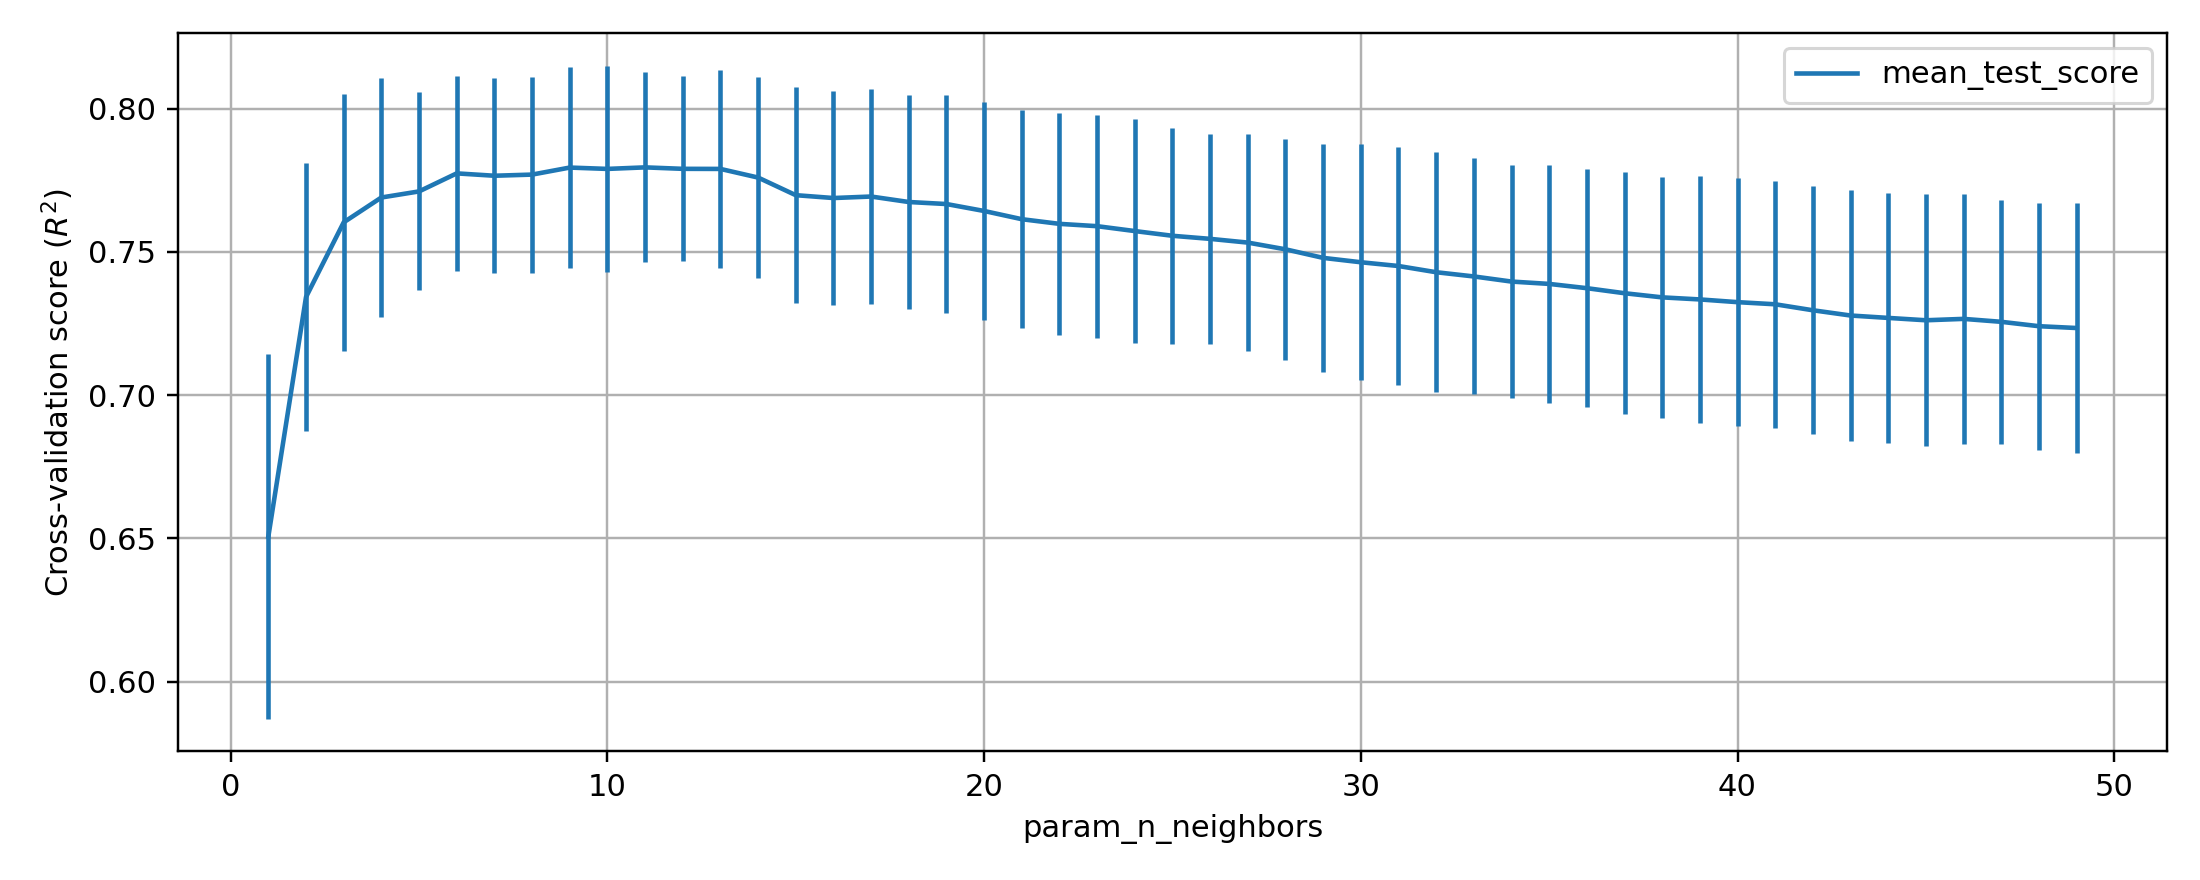

In [20]:
plt.figure(figsize = (10,4))
knn_gridsearch_results.plot(x = 'param_n_neighbors', 
                            y = 'mean_test_score', 
                            yerr = 'std_test_score', 
                            ax = plt.gca())
plt.ylabel('Cross-validation score ($R^2$)')
plt.grid()
plt.tight_layout()

In [21]:
# SOLUTION
knn_gridsearch.best_params_

{'n_neighbors': 11}

In [22]:
# SOLUTION
knn_gridsearch.best_score_

0.7795063363723488

## *Questions*
- a. What is the optimal number of neighbours for this problem? What is the best performance that can be achieved?
- b. The standard deviation is quite high. How can the standard deviation be reduced?
- c. [OPTIONAL]: What about other hyper-parameters? Does changing these (e.g. `weights`, `metric`) improve the model performance?

### *SOLUTION*
- a. The optimal number of neighbours should lie close to the default parameters, between 4-10, and lead to a performance of 0.75-0.8 (deviations possible)
- b. The standard deviation can be reduced by increasing the size of the training dataset.
- c. Other hyper-parameters should not lead to significant improvements in model performance. While other distance metrics (e.g. manhattan, chebychev) are expected to slightly reduce model performance, using `weights = 'distance'` may slightly increase performance.

## Step 2.3: Model testing

##### Load and transform test data
Since in this tutorial we work with scaled data, we should load the scaled test data and extract the features and target similar to the training data:

In [23]:
test_data = pd.read_csv('test_data_scaled.csv', index_col = 0)

In [24]:
X_test = test_data[ features_list ]
y_test = test_data[ target_name ]

In [25]:
X_test_reduced = mutual_info.transform( X_test )

##### Predict test labels

In [26]:
y_test_pred = knn_gridsearch.predict( X_test_reduced )

##### Evaluate the test prediction

In [27]:
# SOLUTION
from sklearn.metrics import mean_absolute_error

In [28]:
# SOLUTION
print('R2 score: %.3f'   % knn_gridsearch.score( X_test_reduced, y_test ) )  # compute R2 and print results
print('MAE: %.2f kWh/m2' % mean_absolute_error(y_test, y_test_pred) )       # compute MAE and print results

R2 score: 0.663
MAE: 92.23 kWh/m2


##### Visualise the test prediction

<IPython.core.display.Javascript object>


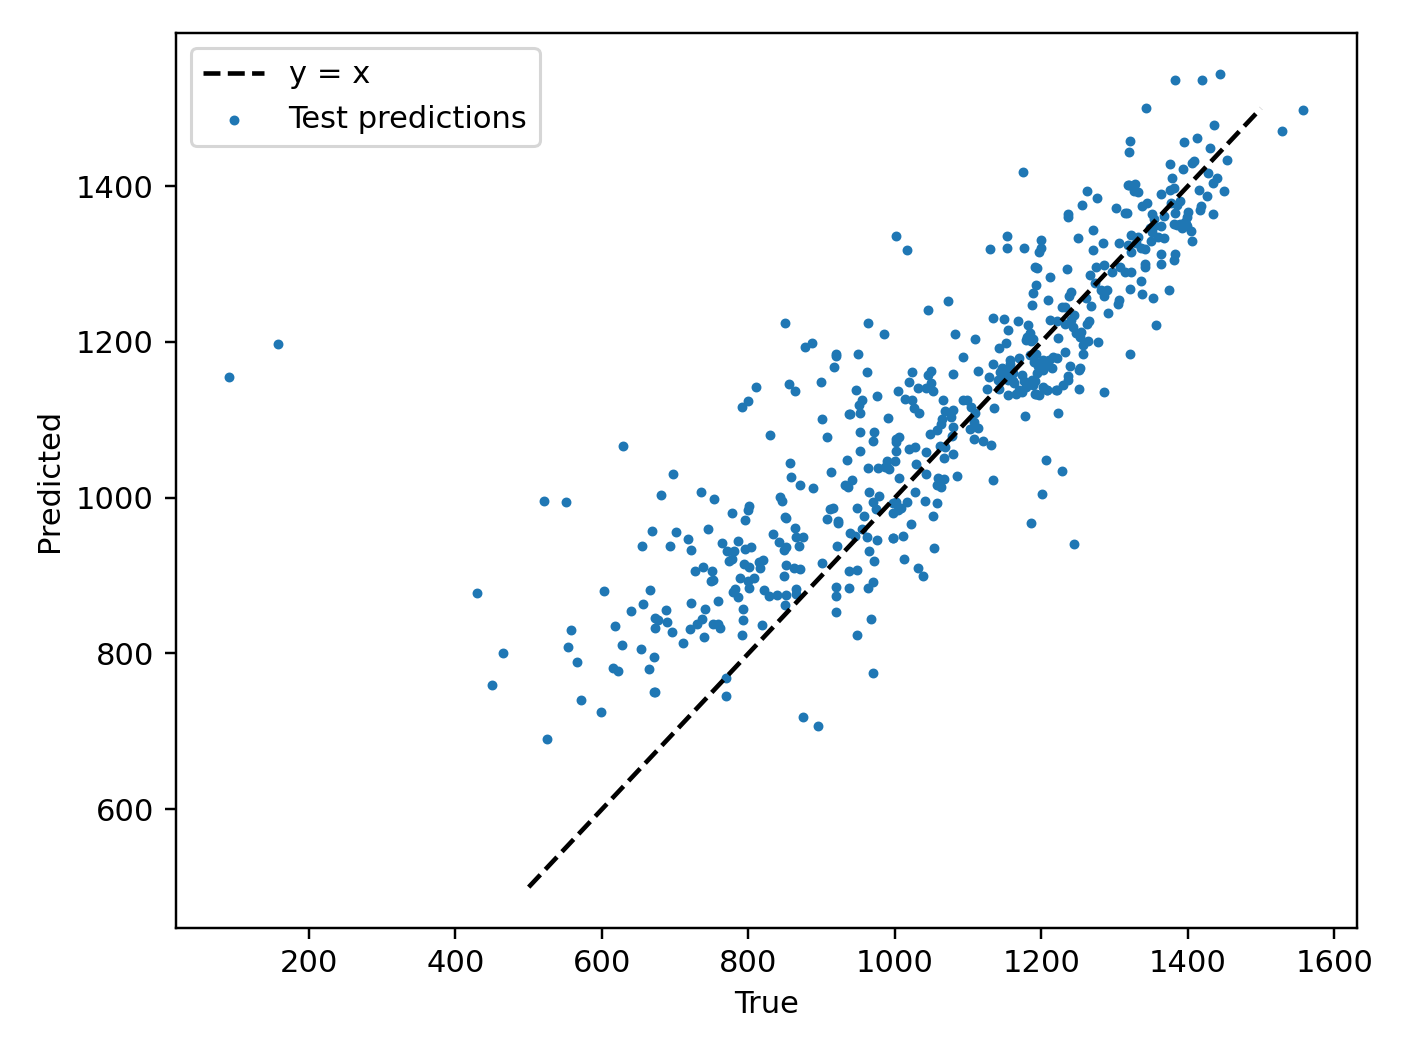

In [29]:
# SOLUTION
plt.figure()
plt.scatter(y_test, y_test_pred, s = 5, label = 'Test predictions')
plt.plot([500,1500], [500,1500], 'k--', label = 'y = x')
plt.legend()
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()

## *Questions*
- a. How does the test score compare to the validation score?
- b. How does the MAE compare to the MAE found for the linear regression in Tutorial 1?
- c. Do you notice any systematic bias in your scatterplot?

### *SOLUTION*
- a. The test score should lie some points below the validation score. This is expected, as the test data does not come from the same geographic area as the training data and the hyper-parameters have not been tuned accounting for this data.
- b. The MAE (and also the R2) are improved compared to the linear regression.
- c. For the KNN, we see some systematic over-estimation for roofs with low solar radiation (i.e. the predictions dift off the y=x line).

# Part 3 - Support Vector Regression (SVR)

The SVR algorithm is imported from the `sklean.svm` module and is documented here:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [30]:
from sklearn.svm import SVR

## *Questions*:
- Which are the main hyper-parameters of SVM and what are their variable names in `scikit-learn`?
- What are the default values of these hyper-parameters?

### *SOLUTION*
The main hyper-parameters of SVR are (see documentation):
1. The kernel function, called `kernel` (default **rbf**). Other popular kernels are the linear (computationally efficient) or polynomial kernel.
2. The error penalisation term `C` (default **1.0**), which determines how strongly missclassifications are penalized in the optmization problem to define the hyperplane.
3. Kernel coefficient $\gamma$, called `gamma` (default **scale**). The default kernel coefficient decreases as the variance and/or the number of features increase.
4. The no-penalty "tube" $\epsilon$, called `epsilon` (default **0.1**), which defines the distance from a predicted point which is non-penalized in the training loss function. If this term is very small, even small deviations from the predicted value are penalized, while large values for $\epsilon$ increase the "tolerance" of the algorithm.

## Step 3.1: Hyper-parameter analysis

Similar to the KNN, let's fit an SVR with default parameters:

In [31]:
# SOLUTION
svr = SVR() # Initiate model
svr.fit(X_train, y_train)   # Fit model with training data

SVR()

In [32]:
# SOLUTION
# Score the training and validation data
print( 'Training score: %.3f'   %svr.score(X_train, y_train) )
print( 'Validation score: %.3f' %svr.score(X_val, y_val) )

Training score: 0.330
Validation score: 0.315


The scores of the default SVR are not satisfactory, so we need to change the hyper-parameters. Here, we will look at two parameters - `C` and `gamma`, while keeping the default kernel and $\epsilon$. 

##### Varying C
Let's start by changing `C` - either to a very small value (0.001) or to a very big value (say, 10,000).

In [33]:
# SOLUTION
svr = SVR(C = 0.001) 
svr.fit(X_train, y_train)   # Fit model with training data

# Score the training and validation data
print( 'Training score: %.3f'   %svr.score(X_train, y_train) )
print( 'Validation score: %.3f' %svr.score(X_val, y_val) )

Training score: -0.003
Validation score: -0.003


In [34]:
# SOLUTION
svr = SVR(C = 10000)
svr.fit(X_train, y_train)   # Fit model with training data

# Score the training and validation data
print( 'Training score: %.3f'   %svr.score(X_train, y_train) )
print( 'Validation score: %.3f' %svr.score(X_val, y_val) )

Training score: 0.916
Validation score: 0.675


##### Varying gamma
To test the performance of `gamma`, we should first understand the default value. Based on the documentation, we can compute `gamma` as: 

In [35]:
gamma_default = 1 / (n_features * X_train.var())
gamma_default

0.1667731666992542

Let's again check some very small (0.00001) and very high (10) values. As the default model performs badly, let's choose a value of `C` that lies somewhere in the expected range (e.g. C = 1000)

In [36]:
# SOLUTION
svr = SVR(gamma = 0.0001, C = 1000)
svr.fit(X_train, y_train)   # Fit model with training data

# Score the training and validation data
print( 'Training score: %.3f'   %svr.score(X_train, y_train) )
print( 'Validation score: %.3f' %svr.score(X_val, y_val) )

Training score: 0.507
Validation score: 0.491


In [37]:
# SOLUTION
svr = SVR(gamma = 1, C = 1000)
svr.fit(X_train, y_train)   # Fit model with training data

# Score the training and validation data
print( 'Training score: %.3f'   %svr.score(X_train, y_train) )
print( 'Validation score: %.3f' %svr.score(X_val, y_val) )

Training score: 0.963
Validation score: 0.703


## *Questions*
- a. How does the default model perform compared to the default KNN?
- b. For which values of `C` does the model over-fit, when does it under-fit?
- c. In which range do you expect the optimal value for `C`?
- d. In which "direction" (increasing, decreasing) does `gamma` lead to overfitting, when does it underfit?

### *SOLUTION*:
- a. The performance of the default SVR is low compared to the default KNN - this shows us that model tuning is extremely important!
- b. If C is too small (as we see for C <= 10), both training and validation score low - the model under-fits the data. If C is too large (see C = 10,000), the training score is very high, while the validation score decreases - this indicates over-fitting.
- c. From the above results, we would expect the optimal C to lie between 1 (the default value) and 10,000 (likely over-fitting)
- d. A small gamma tends to underfit, large gamma leads to over-fitting.

## Step 3.2: Hyperparameter tuning

In [38]:
hyperparams = {
    'C'     : [1, 10, 100, 1000, 10000],      # Get orders of magnitude for C
    'gamma' : [0.0001, 0.001, 0.01, 0.1, 1]   # Get orders of magnitude for gamma
}

With the dictionary of hyper-parameters and after declaring an instance of the default SVR model, we can call the `GridSearchCV` function and fit it with the features and the target.

In [40]:
# SOLUTION
tt = time.time()

svr = SVR()                                        # Initiate default SVR
svr_gridsearch = GridSearchCV(svr, hyperparams)    # Declare GridSearch instance
svr_gridsearch.fit(X_tuning, y)                    # Fit the grid-search (i.e. perform the grid-search)

print('Performed hyperparameter tuning in %.2fs' %(time.time()-tt))

Performed hyperparameter tuning in 10.35s


In [41]:
# SOLUTION
svr_gridsearch_results = pd.DataFrame(svr_gridsearch.cv_results_)
svr_gridsearch_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.022346,0.001641,0.003326,0.000697,1,0.0001,"{'C': 1, 'gamma': 0.0001}",-0.002192,-0.002552,-0.013452,-0.002191,-0.002494,-0.004576,0.004441,25
1,0.019170,0.000225,0.002847,0.000036,1,0.001,"{'C': 1, 'gamma': 0.001}",0.012004,0.012870,0.000444,0.010563,0.012723,0.009721,0.004710,24
2,0.019267,0.000417,0.002902,0.000073,1,0.01,"{'C': 1, 'gamma': 0.01}",0.113055,0.132100,0.109012,0.110393,0.128608,0.118634,0.009720,21


To see how the error changes with `C` and `gamma`, we can extract the `mean_test_score`. The data is best understandable if we expand it to two dimensions, one for C and one for gamma. For this, we can use panda's `pivot()` function:

In [42]:
mean_val_score = svr_gridsearch_results.pivot(values = 'mean_test_score',   # Values to popoulate the 2D datagrame
                                              index = 'param_C',            # New index
                                              columns = 'param_gamma')      # New columns

Which we can then display as a formatted matrix:

In [43]:
format_df( mean_val_score, cmap='YlGn', decimals = 3)

param_gamma,0.0001,0.001,0.01,0.1,1.0
param_C,,,,,
1,-0.00458,0.00972,0.119,0.336,0.0888
10,0.00997,0.136,0.507,0.726,0.462
100,0.138,0.507,0.681,0.818,0.697
1000,0.506,0.598,0.803,0.824,0.727
10000,0.586,0.685,0.818,0.788,0.673


We can also look at the time for fitting and scoring:

In [44]:
# SOLUTION
mean_fit_time = svr_gridsearch_results.pivot(values = 'mean_fit_time', index = 'param_C', columns = 'param_gamma')

In [45]:
format_df( mean_fit_time, cmap='autumn_r', decimals = 3)

param_gamma,0.0001,0.001,0.01,0.1,1.0
param_C,,,,,
1,0.0223,0.0192,0.0193,0.0196,0.0296
10,0.0335,0.0208,0.021,0.0212,0.0236
100,0.021,0.0203,0.0234,0.0336,0.0358
1000,0.0235,0.0333,0.035,0.0748,0.179
10000,0.0202,0.0304,0.0697,0.687,0.43


In [46]:
# SOLUTION
mean_score_time = svr_gridsearch_results.pivot(values = 'mean_score_time', index = 'param_C', columns = 'param_gamma')
format_df( mean_score_time, cmap='autumn_r', decimals = 2)

param_gamma,0.0001,0.001,0.01,0.1,1.0
param_C,,,,,
1,0.0033,0.0028,0.0029,0.0033,0.0065
10,0.0035,0.0033,0.0031,0.0033,0.0034
100,0.0034,0.0031,0.0029,0.0043,0.0029
1000,0.0032,0.0043,0.003,0.0037,0.003
10000,0.0029,0.003,0.003,0.0037,0.0035


In [47]:
# SOLUTION (proposition - this can vary depending on your data re-shuffle!)
# Iteration 2: Choose approx. logarithmic intervals (1,2,5,10,...) around the magnitudes with the highest score
hyperparams = {
    'C'     : [100, 200, 500, 1000, 2000, 5000, 10000],      # Get orders of magnitude for C
    'gamma' : [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]   # Get orders of magnitude for gamma
}

In [48]:
# SOLUTION (proposition - this can vary depending on your data re-shuffle!)
# Iteration 3: Choose linear intervals around the new best parameters:
hyperparams = {
    'C'     : np.arange(100, 1500, 100),      # Get orders of magnitude for C
    'gamma' : np.arange(0.05, 0.15, 0.01).round(2)   # Get orders of magnitude for gamma
}

# Display dictionary:
hyperparams

{'C': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
        1200, 1300, 1400]),
 'gamma': array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14])}

In [49]:
# SOLUTION - new svr_gridsearch instance:
tt = time.time()

svr = SVR()                                        # Initiate default SVR
svr_gridsearch = GridSearchCV(svr, hyperparams)    # Declare GridSearch instance
svr_gridsearch.fit(X_tuning, y)                    # Fit the grid-search (i.e. perform the grid-search)

print('Performed hyperparameter tuning in %.2fs' %(time.time()-tt))

Performed hyperparameter tuning in 39.82s


In [50]:
# SOLUTION - new CV score matrix:
svr_gridsearch_results = pd.DataFrame(svr_gridsearch.cv_results_)

mean_val_score = svr_gridsearch_results.pivot(values = 'mean_test_score',   # Values to popoulate the 2D datagrame
                                              index = 'param_C',            # New index
                                              columns = 'param_gamma')      # New columns
format_df( mean_val_score, cmap='YlGn', decimals = 3)

param_gamma,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14
param_C,,,,,,,,,,
100,0.814,0.816,0.818,0.818,0.818,0.818,0.818,0.818,0.817,0.817
200,0.82,0.822,0.823,0.823,0.823,0.824,0.823,0.823,0.823,0.822
300,0.822,0.824,0.824,0.824,0.824,0.825,0.825,0.825,0.824,0.824
400,0.823,0.824,0.824,0.825,0.825,0.825,0.826,0.825,0.825,0.824
500,0.824,0.824,0.825,0.826,0.826,0.826,0.826,0.826,0.825,0.824
600,0.824,0.824,0.825,0.826,0.826,0.827,0.826,0.825,0.824,0.824
700,0.824,0.824,0.826,0.826,0.827,0.827,0.825,0.824,0.824,0.823
800,0.824,0.825,0.825,0.826,0.827,0.826,0.825,0.824,0.823,0.823
900,0.824,0.825,0.826,0.826,0.826,0.825,0.824,0.823,0.823,0.822


In [51]:
# SOLUTION: Final best parameters:
svr_gridsearch.best_params_

{'C': 600, 'gamma': 0.1}

## *Questions*
- a. In which range do you find the best hyper-parameters?
- b. Which process (fitting or scoring) is more time-intensive for the SVR?
- c. How do the fitting times compare to the performance? Do you notice a pattern? What does this suggest about the over/underfitting of the model?
- [OPTIONAL] d. Expand the model tuning by other hyper-parameters. What is the best score that you can achieve? What are the hyper-parameters to achieve this score? 

### *SOLUTION*
- a. The best hyper-parameters are found for gamma around 0.06-0.11 (slightly below the default value) and for C around 500-1000. Around these we see a "channel" of near-optimal solutions in the colored matrix, which implies some trade-off between a high `C` and a high `gamma`.
- b. The fitting is significantly more time-intensive. This is the case for most ML algorithms (except KNN, which has a very simple fitting procedure and performs all the "work" during prediction).
- c. The fitting times increase with `C` and `gamma`. The scores decrease in the direction of the lowest fitting times (low C and low gamma), and towards the highest fitting times (high C and high gamma). Bad performance with low fitting times suggest **underfitting**, as the model is very simple. High training times and low performance, on the other hand, suggest **overfitting**, since too much time is spent fitting exactly to the data.
- d. This exercise is mostly for your practice and interest. You should be able to improve the performance by another small margin.

## Step 3.3: Evaluate the test set
Similar to the KNN, we should evaluate the prediction on the test set:

In [52]:
y_test_pred_svr = svr_gridsearch.predict( X_test_reduced )

In [53]:
# SOLUTION
print('R2 score: %.3f' %svr_gridsearch.score( X_test_reduced, y_test ) )  # compute R2 and print results
print('MAE: %.2f kWh/m2' %mean_absolute_error(y_test, y_test_pred_svr) )       # compute MAE and print results

R2 score: 0.746
MAE: 71.09 kWh/m2


<IPython.core.display.Javascript object>


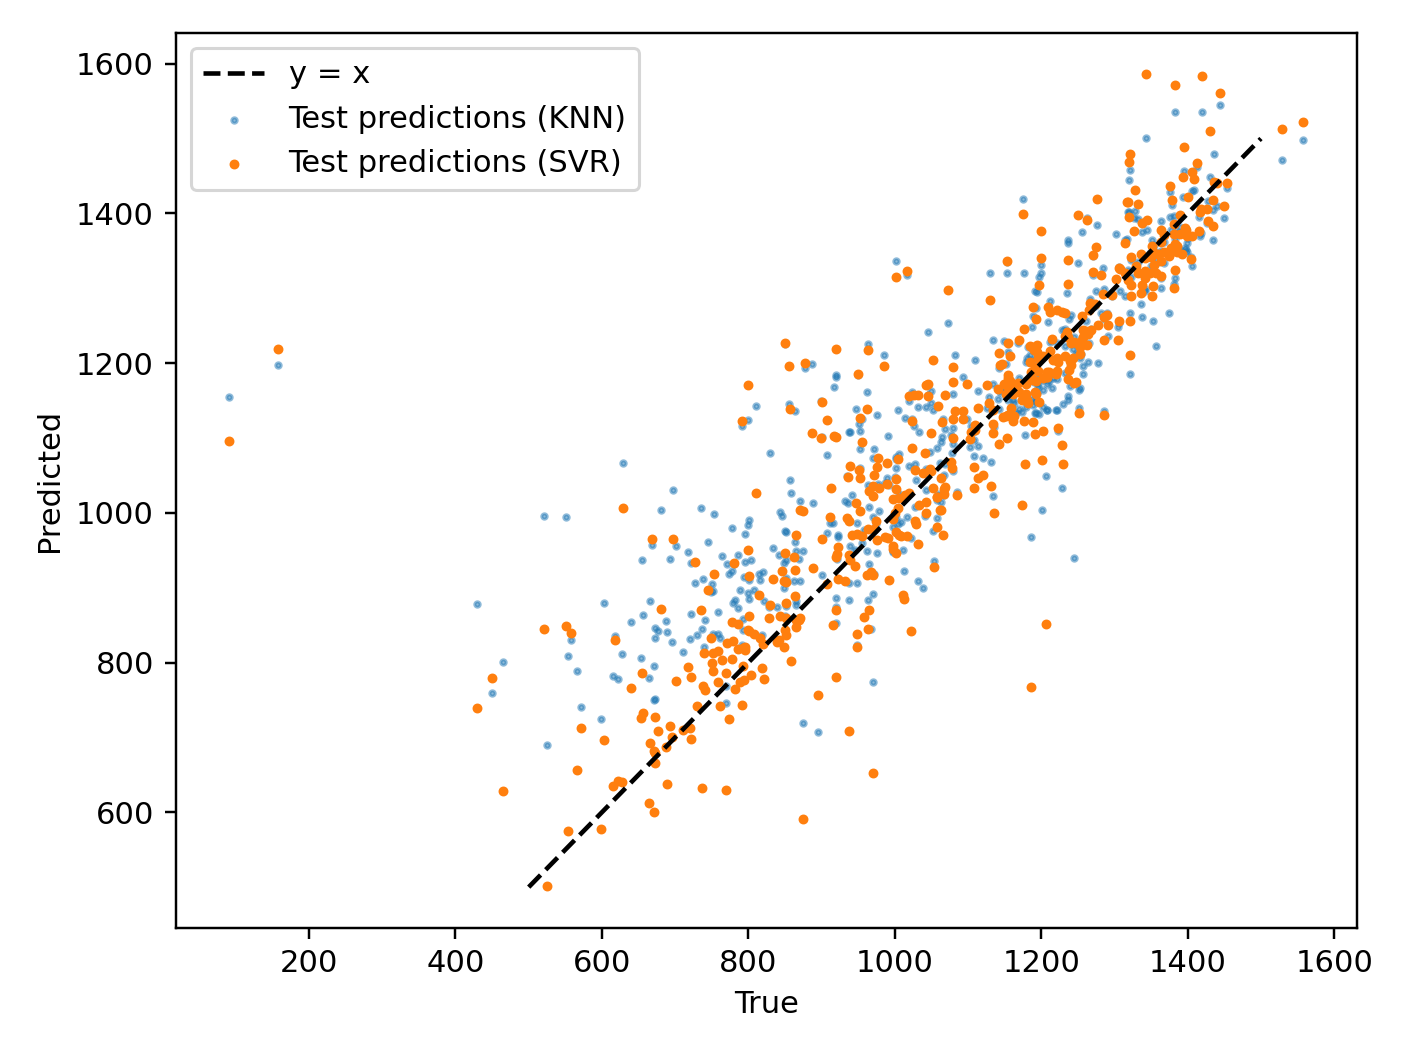

In [54]:
# SOLUTION
plt.figure()
plt.scatter(y_test, y_test_pred, s = 3, label = 'Test predictions (KNN)', alpha = 0.5)
plt.scatter(y_test, y_test_pred_svr, s = 5, label = 'Test predictions (SVR)')
plt.plot([500,1500], [500,1500], 'k--', label = 'y = x')
plt.legend()
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()

## *Questions*
- a. How does the test performance of the SVR compare to test performance of the KNN (R2 and MAE)?
- b. How to the scatterplots of the two test predictions compare?

### *SOLUTION*
- a. The test performance of the tuned SVR should lie slightly above the performance of the tuned KNN, around 0.7-0.75, while the MAE should be lower (around 70 kWh/m2). The SVR hence performs better than the KNN in this regression task.
- b. The scatterplot shows that the drift for low values of tilted radiation, which we observe for the KNN, cannot be observed for the SVR. The improvement in performance hence mostly arises from a better prediction for low values of solar radiation.